<a href="https://colab.research.google.com/github/Meralbalik/Capstone-Project-2/blob/master/CP2_confmatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN For Detecting Pneumonia From X-Ray Images

This notebook demonstrates classification of chest X-ray images with deep learning using a CNN from scratch. 

##  Using GPU

In [1]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.0 GB  | Proc size: 1.1 GB
GPU RAM Free: 14860MB | Used: 219MB | Util   1% | Total 15079MB


In [3]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Downloading the dataset 

In [4]:
# listing the files in the directory
!ls '/content/drive/My Drive/Colab Notebooks/chest_xray/'

chest_xray  __MACOSX  test  train  val


In [5]:
data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'
!ls data_path

ls: cannot access 'data_path': No such file or directory


In [0]:
# importing necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [0]:
# assigning variables with the proper file path for the training, validation and test set
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

In [0]:
# assigning variables with the proper file path for the normal and pneumonia images 
train_normal_dir = os.path.join(train_dir, 'NORMAL')  
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')  
val_normal_dir = os.path.join(val_dir, 'NORMAL') 
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA') 
test_normal_dir = os.path.join(test_dir, 'NORMAL')  
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA') 

In [9]:
# looking at how many images there are in each directory
dir = [train_normal_dir, train_pneumonia_dir, val_normal_dir,
            val_pneumonia_dir, test_normal_dir, test_pneumonia_dir]
dir_name = ['train_normal_dir', 'train_pneumonia_dir', 'val_normal_dir',
            'val_pneumonia_dir', 'test_normal_dir', 'test_pneumonia_dir']
for name, dir in zip(dir_name, dir):
  num_of_images = len(os.listdir(dir))
  print ('Number of images in {}: {}'.format(name, num_of_images))

Number of images in train_normal_dir: 1354
Number of images in train_pneumonia_dir: 3875
Number of images in val_normal_dir: 8
Number of images in val_pneumonia_dir: 8
Number of images in test_normal_dir: 234
Number of images in test_pneumonia_dir: 390


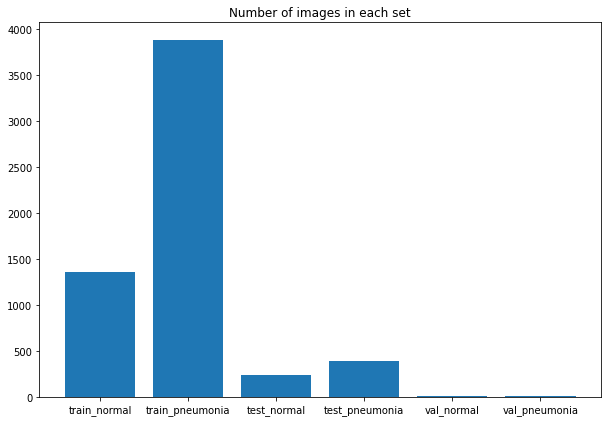

In [10]:
# visualizing the number of images in each folder
fig = plt.figure()
ax = fig.add_axes([0,0,1.3,1.3])
dir_name_ = [train_normal_dir, train_pneumonia_dir, test_normal_dir,
             test_pneumonia_dir,val_normal_dir, val_pneumonia_dir, ]
size = []
for dir in dir_name_:
  l = len(os.listdir(dir))
  size.append(l)
ax.bar(dir_name_,size)
labels = ['train_normal', 'train_pneumonia', 'test_normal', 
          'test_pneumonia','val_normal', 'val_pneumonia',]
ax.set_title('Number of images in each set')
ax.set_xticklabels(labels)
plt.show()

Text(0.5, 1.0, 'Test set, Condition: Pneumonia')

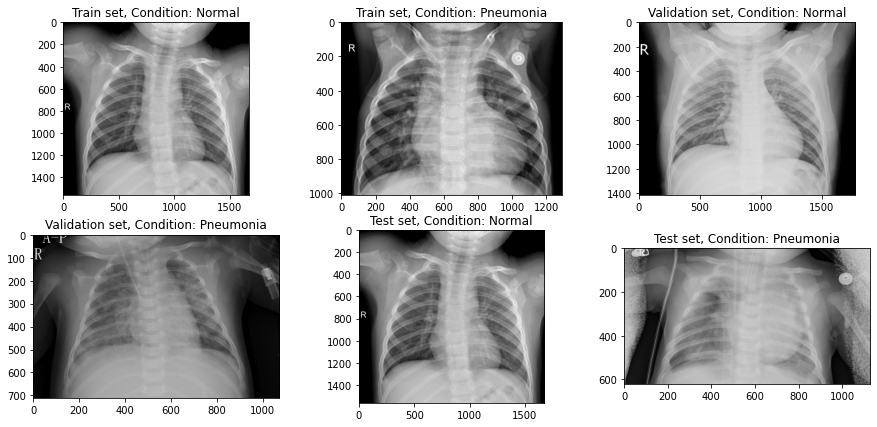

In [11]:
# example images from each folder
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
#plt.tight_layout()

ax[0].imshow(plt.imread(os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])), cmap='gray')
ax[0].set_title('Train set, Condition: Normal')
ax[1].imshow(plt.imread(os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[0])), cmap='gray')
ax[1].set_title('Train set, Condition: Pneumonia')
ax[2].imshow(plt.imread(os.path.join(val_normal_dir, os.listdir(val_normal_dir)[0])), cmap='gray')
ax[2].set_title('Validation set, Condition: Normal')
ax[3].imshow(plt.imread(os.path.join(val_pneumonia_dir, os.listdir(val_pneumonia_dir)[0])), cmap='gray')
ax[3].set_title('Validation set, Condition: Pneumonia')
ax[4].imshow(plt.imread(os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])), cmap='gray')
ax[4].set_title('Test set, Condition: Normal')
ax[5].imshow(plt.imread(os.path.join(test_pneumonia_dir, os.listdir(test_pneumonia_dir)[0])), cmap='gray')
ax[5].set_title('Test set, Condition: Pneumonia')


## Data Preperation
ImageDataGenerator class provided by tf.keras can read images from disk and preprocess them into proper tensors. It will also set up generators that convert these images into batches of tensors—helpful when training the network.

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
train_image_generator = ImageDataGenerator(rescale=1./255,  
                                           horizontal_flip=True) # Generator for training data
val_image_generator = ImageDataGenerator(rescale=1./255) # Generator for validation data
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for test data

After defining the generators for training and validation images, the flow_from_directory method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [0]:
# defining the hyperparameters
batch_size = 16
epochs = 20
img_height = 150
img_width = 150

In [14]:
# distribution of the datasets
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(img_height, img_width),
                                                           class_mode='binary',
                                                           shuffle=True)
val_data_gen = val_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=val_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary',shuffle=True
                                                             )
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(img_height, img_width),
                                                              class_mode='binary',
                                                              shuffle=True)

Found 5229 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
print("Shape of training images {}".format(train_data_gen.image_shape))
print("Shape of test images {}".format(test_data_gen.image_shape))
print("Shape of validation images {}".format(val_data_gen.image_shape))

Shape of training images (150, 150, 3)
Shape of test images (150, 150, 3)
Shape of validation images (150, 150, 3)


## Implement the CNN architecture with Keras

In [0]:
# importing necessary packages
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
#tf.set_random_seed(seed)
tf.random.set_seed(seed) 

In [0]:
# creating the CNN architecture
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', 
                 input_shape=(img_height, img_width ,3)))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))


## Compile Model

In [0]:
# load weights
#model.load_weights("best_weights.hdf5")

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

In [20]:
# number of images for both train and test sets
total_train = len(os.listdir(train_normal_dir)) + len(os.listdir(train_pneumonia_dir))
total_test = len(os.listdir(test_normal_dir)) + len(os.listdir(test_pneumonia_dir))
total_val = len(os.listdir(val_normal_dir)) + len(os.listdir(val_pneumonia_dir))
print(total_train, total_test, total_val)

5229 624 16


In [21]:
# fitting the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', monitor='val_loss', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, mode='auto',verbose=1)

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = total_train // batch_size, 
    epochs=epochs,
    validation_data = val_data_gen,
    validation_steps = total_val // batch_size,
    callbacks = [early_stopping, lr_reduce, checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
326/326 [==============================] - 64s 195ms/step - loss: 0.5537 - accuracy: 0.8451 - val_loss: 0.7891 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/20
326/326 [==============================] - 62s 191ms/step - loss: 0.1834 - accuracy: 0.9309 - val_loss: 9.5252 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
326/326 [==============================] - 62s 190ms/step - loss: 0.1329 - accuracy: 0.9490 - val_loss: 0.2664 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/20
326/326 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9586
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 62s 191ms/step - loss: 0.1166 - accuracy: 0.9586 - val_loss: 0.4389 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 5/20
326/326 [==============================] - 62s 189ms/step - loss: 0.0867 - accuracy: 0.9674 - val_loss: 0.2229 - val

## Evaluate Model

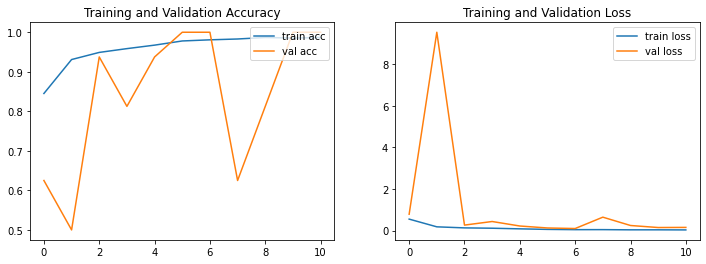

In [22]:
# plotting model accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
# Test your model on unknown samples (testing data)
test_loss, test_acc = model.evaluate_generator(test_data_gen, steps=16)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test accuracy: 0.76953125
Test loss: 1.3571685552597046


In [0]:
# saving model in H5 format.
model.save('pneumonia.h5')

In [25]:
import cv2
from collections import Counter

data_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/chest_xray/'

# making predictions off of the test set 
# This is useful to be able to get the confusion matrix
test_data = []
test_labels = []

for cond in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(data_path + 'test' + cond)):
        img = plt.imread(data_path +'test'+ cond + img)
        img = cv2.resize(img, (img_height, img_width))
        img = np.dstack([img, img, img]) #concatenates along the third dimension
        img = img.astype('float32') / 255
        if cond =='/NORMAL/':
            label = 0
        elif cond =='/PNEUMONIA/':
            label = 1
        test_data.append(img)
        test_labels.append(label)
        
test_data = np.array(test_data)
test_labels = np.array(test_labels)
    
print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", Counter(test_labels)) 

Total number of test examples:  (624, 150, 150, 3)
Total number of labels: Counter({1: 390, 0: 234})


In [26]:
import seaborn as sns
# creating a function that plots the confusion matrix
def conf_matrix(conf_mat):
    labels = ['NORMAL', 'PNEUMONIA']
    ax=sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels,
                   annot=True, fmt='d', cmap="Blues")
    ax.set_title('Confusion Matrix')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))

              precision    recall  f1-score   support

           0       1.00      0.32      0.49       234
           1       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.86      0.66      0.66       624
weighted avg       0.82      0.75      0.70       624



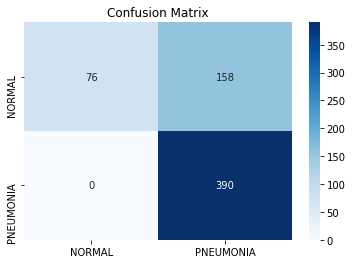

In [28]:
# calling the confusion matrix    
conf_matrix(cm)

print(classification_report(test_labels, np.round(preds)))